## purpose 
   - prophetで同じ対象の予測を行い、LSTMの性能と比較すること


## TODOs
   - 売上データ作成
   - モデルに読み込ませる時系列データ作成
   - 学習データをprophetに読み込ませて学習
   - prophetの性能評価

In [1]:
!git clone https://github.com/facebook/prophet.git
!pip install convertdate lunarcalendar holidays==0.9.12
!pip install pystan==2.17.1.0 -i https://pypi.tuna.tsinghua.edu.cn/simple
!python3 prophet/python/setup.py install

fatal: destination path 'prophet' already exists and is not an empty directory.
You should consider upgrading via the 'pip install --upgrade pip' command.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the 'pip install --upgrade pip' command.
Traceback (most recent call last):
  File "prophet/python/setup.py", line 117, in <module>
    with open('requirements.txt', 'r') as f:
FileNotFoundError: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
!pip install fbprophet

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from fbprophet import Prophet

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
df = pd.read_csv('train_data.csv').sort_values('dt')

In [7]:
biz_category_list = list(set(df['biz_category']))
print(biz_category_list)
data_list_tmp = [df[df['biz_category'] == biz_category] for biz_category in biz_category_list]

['ゲーム', 'その他', 'ライブコミュニケーション', '同人', '電子書籍', '動画']


In [8]:
device_category_list = list(set(df['category']))

print(device_category_list)

data_list = []
for device_category in device_category_list:
    for data in data_list_tmp:
        data_list.append(data[data['category'] == device_category].loc[:, ['dt', 'nontax_amount']])

#print([len(data) for data in data_list])　　# 長さ確認

['01.multi_device', '02.pc_only', '03.sp_only']


In [9]:
# 学習データ可視化する関数
def plot_sales(
    x, y, 
    category_list, data_list,
    num_biz_cotegory, num_device_category, line_width):

    ax_list = []

    for i in range(len(category_list)):
        ax_list.append(
            {
                'ax':fig.add_subplot(num_biz_cotegory, num_device_category, i + 1),
                'category':category_list[i],
                 'data':data_list[i]
                 }
            )

    for ax in ax_list:
        ax['ax'].tick_params(labelbottom='off')
        ax['ax'].set_title(ax['category'])
        ax['ax'].plot(x, y, data=ax['data'], linewidth=line_width)

In [10]:
category_list = []
for device_category in device_category_list:
    for biz_category in biz_category_list:
        category_list.append(biz_category + '_' + device_category)

In [ ]:
# 学習データ可視化
fig = plt.figure(figsize=(18, 18))
#df['dt'] = pd.to_datetime(df['dt'])
#df = df.set_index('dt')
plot_sales('dt', 'nontax_amount', category_list, data_list, 6, 3, 1)

### モデルに読み込ませる時系列データ作成

In [71]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

np.random.seed(7)

In [72]:
# 入力に用いる変数のリストを作る
input_list = []

for device_category in device_category_list:
    for data in data_list_tmp:
        input_list.append(data[data['category'] == device_category].loc[:, ['dt', 'nontax_amount']]) #.astype('float32')

In [73]:
input_df_list = []
for i in range(len(input_list)):
    input_df_list.append(pd.DataFrame(input_list[i]))
input_df_list[0].head()

dt  nontax_amount
15  2017-07-04        4471912
26  2017-09-09        4502182
33  2017-12-28       10389142
38  2018-02-02        4547361
42  2018-05-06        2518280

In [74]:
#　売上のみのリスト作成
dataset_list = []
dt_list = []
for data in data_list:
    dt_list.append(data['dt'].values)
    dataset_list.append(data['nontax_amount'].values)
dt_list[0]

array(['2017-07-04', '2017-09-09', '2017-12-28', ..., '2019-04-29',
       '2019-06-01', '2019-07-07'], dtype=object)

In [75]:
scaler_list = []
scaled_dataset_list = []

for data in dataset_list:
    scaler = MinMaxScaler(feature_range=(0, 1))
    # 前処理したデータを格納
    scaler_list.append(scaler.fit(data.reshape(-1, 1)))
    scaled_dataset_list.append(scaler.transform(data.reshape(-1, 1)))
scaled_dataset_list[1][0]

array([0.08277527])

In [76]:
for i in range(len(input_df_list)):
    input_df_list[i]['nontax_amount']=scaled_dataset_list[i]

In [77]:
rename_input_df_list = []
for input_df in input_df_list:
    rename_input_df_list.append(input_df.reset_index().rename(columns={'dt':'ds', 'nontax_amount':'y'}))
    
rename_input_df_list[17].head()

index          ds         y
0     17  2017-08-19  0.369742
1     31  2017-12-28  0.345880
2     40  2018-05-06  0.785454
3     64  2018-12-13  0.343917
4     79  2019-03-14  0.289723

In [20]:
# データをtrainとtestに分ける

train_size = int(len(scaled_dataset_list[0]) * 0.67)  #　モデルのトレーニングに使用するデータのサイズ
test_size = len(scaled_dataset_list[0]) - train_size 

train_list = [data[0:train_size,:] for data in scaled_dataset_list]
test_list = [data[train_size:len(data),:] for data in scaled_dataset_list]
print(f'train_list shape: {np.array(train_list).shape}')
print(f'test_list shape: {np.array(test_list).shape}')

train_list shape: (18, 346, 2)
test_list shape: (18, 171, 2)


In [21]:
# モデルに読み込ませるデータ生成
def generate_dataset(dataset, length_per_unit):
    # 時系列データ
    sequences = []
    # 正解データ
    target = []
    
    for i in range(len(dataset) - length_per_unit - 1):
        a = dataset[i:(i+length_per_unit), 0]
        sequences.append(a)
        target.append(dataset[i + length_per_unit, 0])
        
        X, Y = np.array(sequences), np.array(target)
    return X, Y

In [34]:
# 一つの時系列データの長さ
LENGTH_PER_UNIT = 7

train_xy_list = [generate_dataset(train, LENGTH_PER_UNIT) for train in train_list] 
test_xy_list = [generate_dataset(test, LENGTH_PER_UNIT) for test in test_list]

In [35]:
# reshape input to be [samples, time steps, features]
train_x_list = [np.reshape(train_xy[0], (train_xy[0].shape[0], 1, train_xy[0].shape[1])) for train_xy in train_xy_list]
test_x_list = [np.reshape(test_xy[0], (test_xy[0].shape[0], 1, test_xy[0].shape[1])) for test_xy in test_xy_list] 
print(f'train_x_list: {np.array(train_x_list).shape}')
print(f'test_x_list: {np.array(test_x_list).shape}')

train_x_list: (18, 344, 1, 1)
test_x_list: (18, 169, 1, 1)


### モデル適用

In [79]:
def build_model(rename_input_df): # , x_test, y_test
    model = Prophet(growth='linear', daily_seasonality=False)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # 月周期性追加
    model.fit(rename_input_df)   
    return model

model_list = []

for i in range(len(category_list)):
    print(i)
    print(category_list[i])
    model_list.append(build_model(rename_input_df_list[i]))#, train_y_list[i], test_y_list
    print('')

0
ゲーム_01.multi_device


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




1
その他_01.multi_device

2
ライブコミュニケーション_01.multi_device


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




3
同人_01.multi_device


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




4
電子書籍_01.multi_device

5
動画_01.multi_device


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




6
ゲーム_02.pc_only


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




7
その他_02.pc_only


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




8
ライブコミュニケーション_02.pc_only


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




9
同人_02.pc_only


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




10
電子書籍_02.pc_only


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




11
動画_02.pc_only


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




12
ゲーム_03.sp_only


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




13
その他_03.sp_only


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




14
ライブコミュニケーション_03.sp_only


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




15
同人_03.sp_only

16
電子書籍_03.sp_only


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.




17
動画_03.sp_only



/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



### 予測

0


<Figure size 72x72 with 0 Axes>

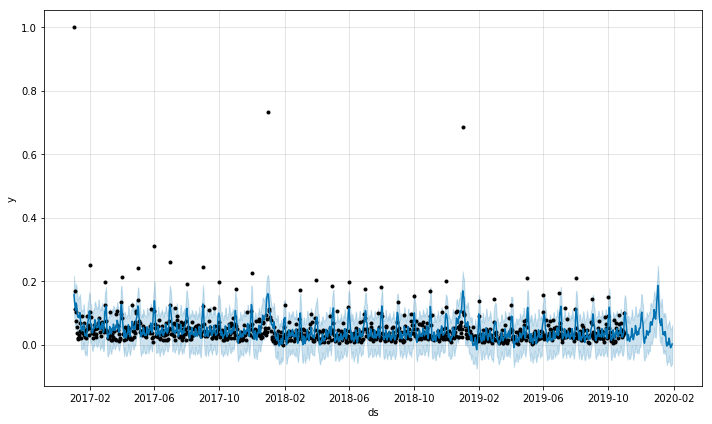

1


<Figure size 72x72 with 0 Axes>

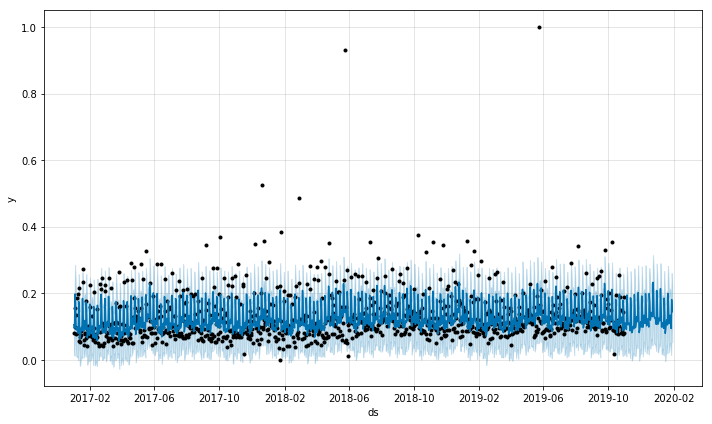

2


<Figure size 72x72 with 0 Axes>

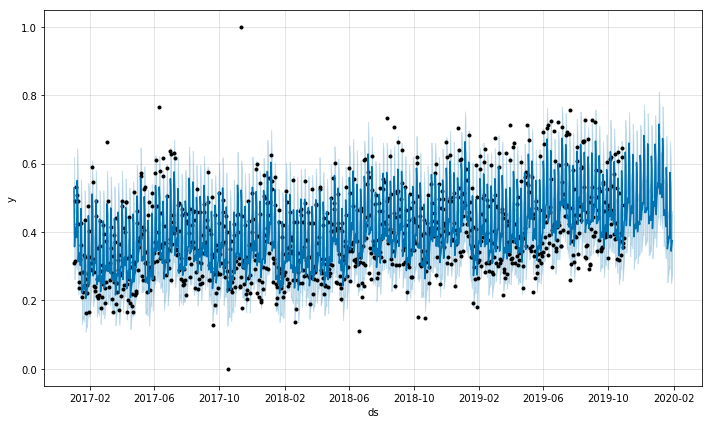

3


<Figure size 72x72 with 0 Axes>

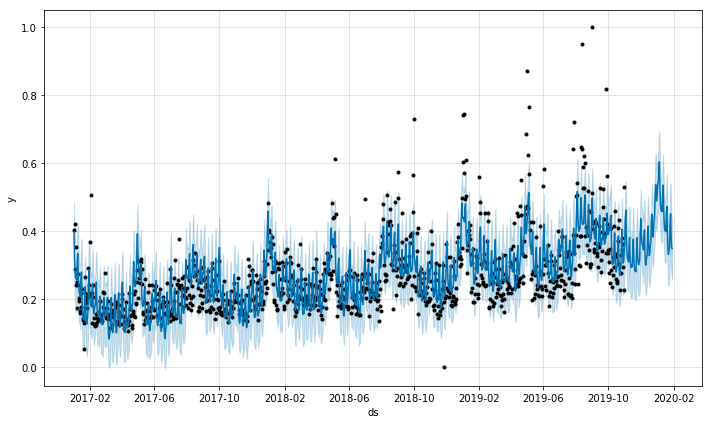

4


<Figure size 72x72 with 0 Axes>

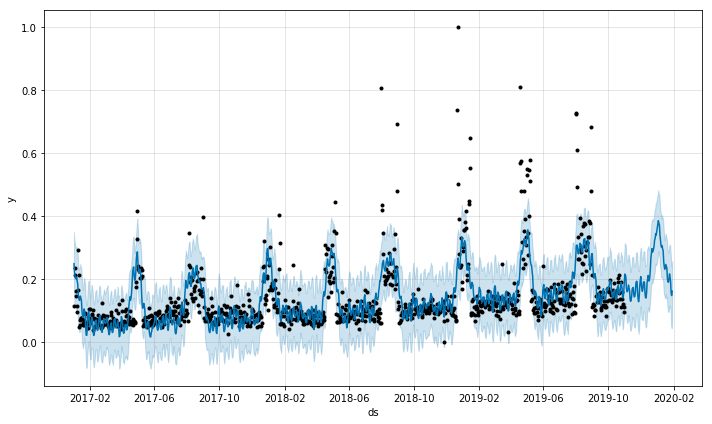

5


<Figure size 72x72 with 0 Axes>

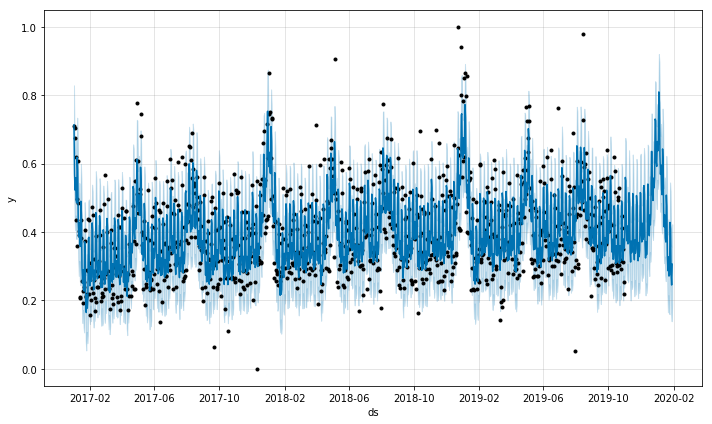

6


<Figure size 72x72 with 0 Axes>

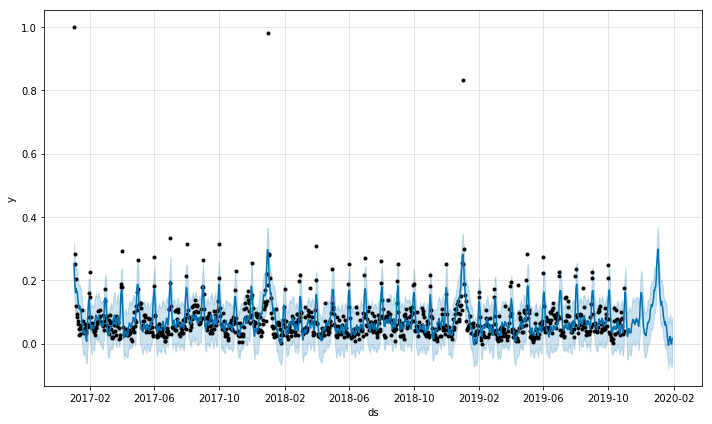

7


<Figure size 72x72 with 0 Axes>

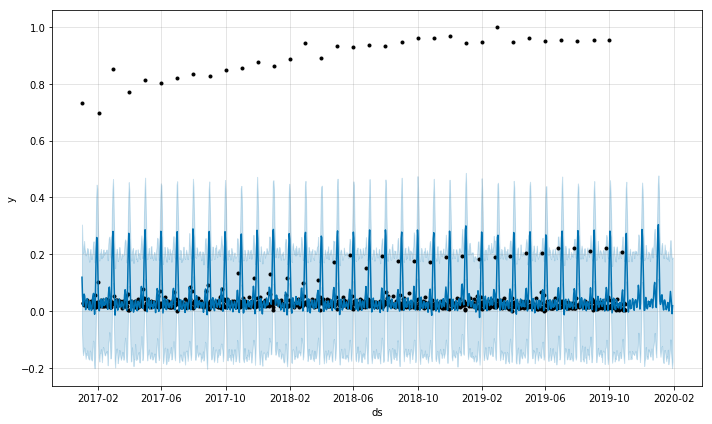

8


<Figure size 72x72 with 0 Axes>

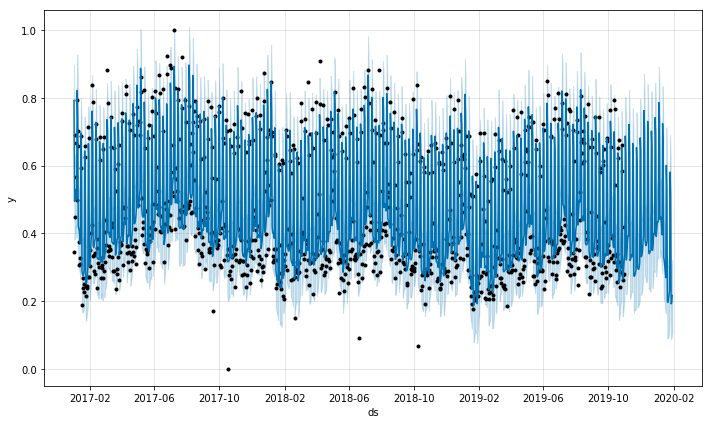

9


<Figure size 72x72 with 0 Axes>

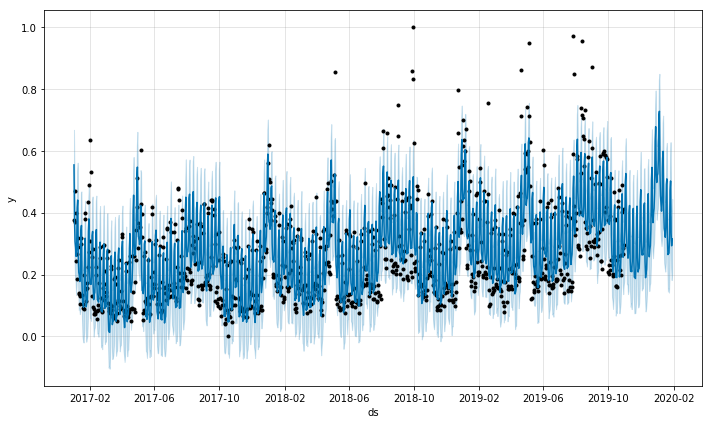

10


<Figure size 72x72 with 0 Axes>

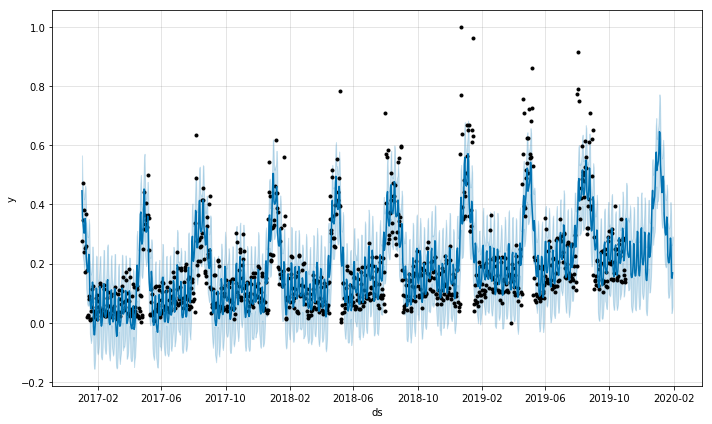

11


<Figure size 72x72 with 0 Axes>

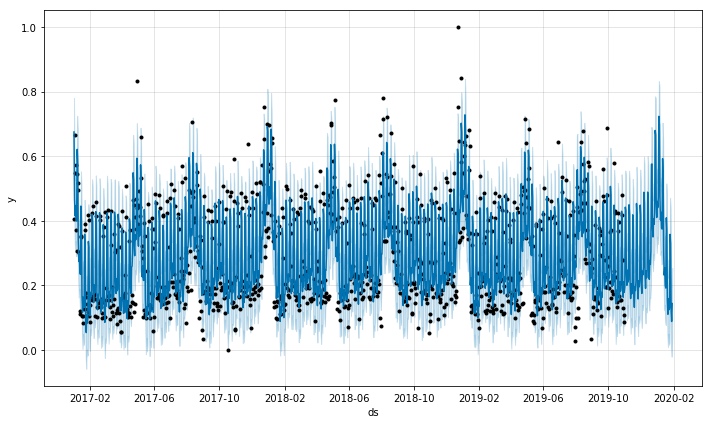

12


<Figure size 72x72 with 0 Axes>

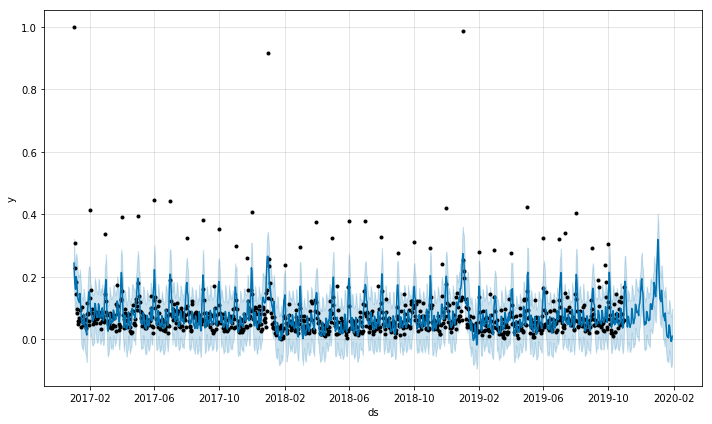

13


<Figure size 72x72 with 0 Axes>

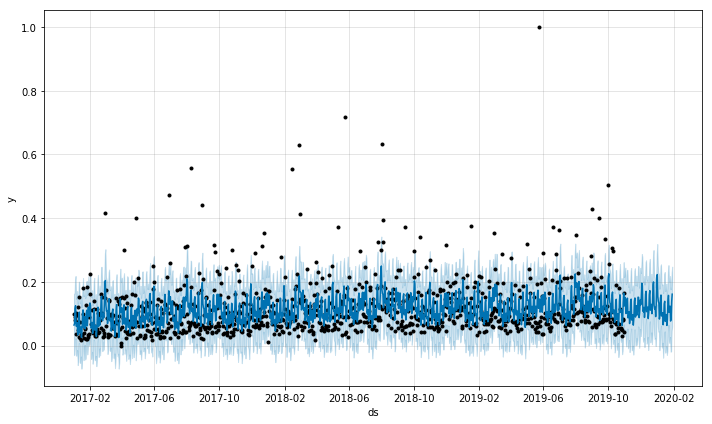

14


<Figure size 72x72 with 0 Axes>

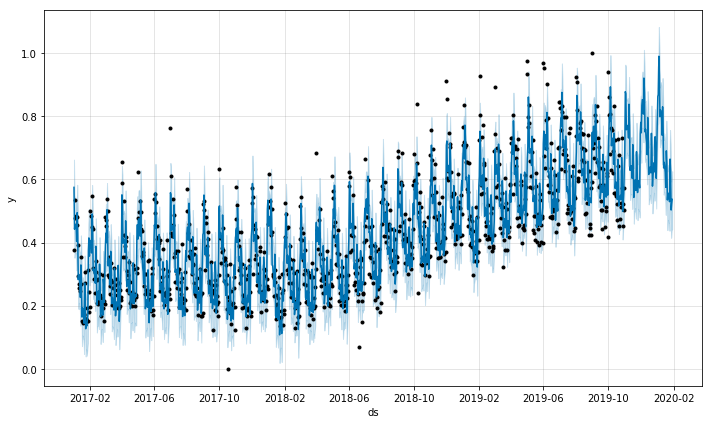

15


<Figure size 72x72 with 0 Axes>

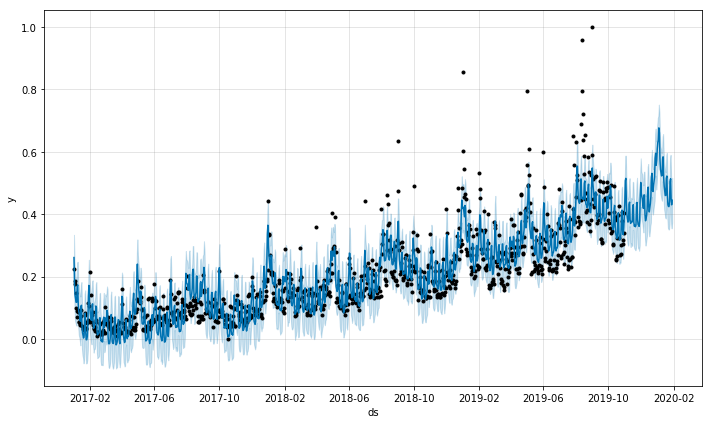

16


<Figure size 72x72 with 0 Axes>

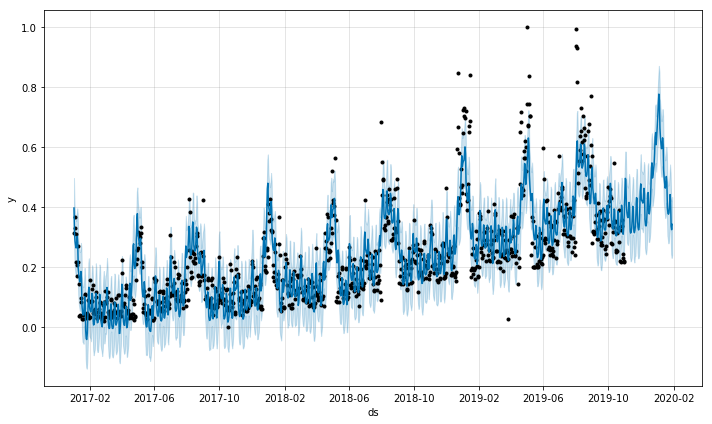

17


<Figure size 72x72 with 0 Axes>

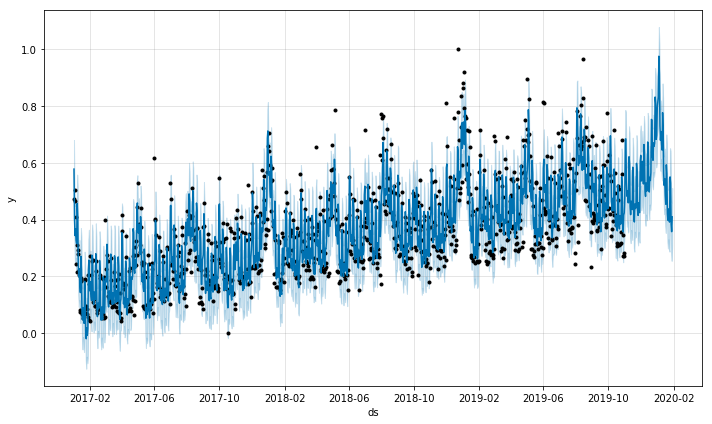

In [80]:
future_list =[]
forecast_list = []
for i in range(len(category_list)):
    print(i)
    fig = plt.figure(figsize=(1, 1))
    future_list.append(model_list[i].make_future_dataframe(periods=90))
    forecast_list.append(model_list[i].predict(future_list[i]))
    model_list[i].plot(forecast_list[i])
    plt.show()

### トレンド性と周期性の抽出

0: ゲーム_01.multi_device


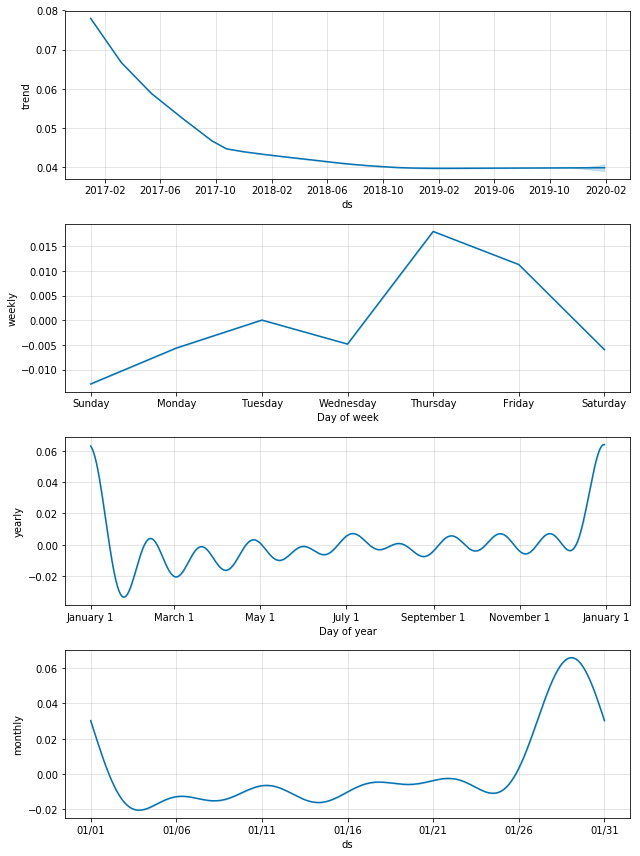

1: その他_01.multi_device


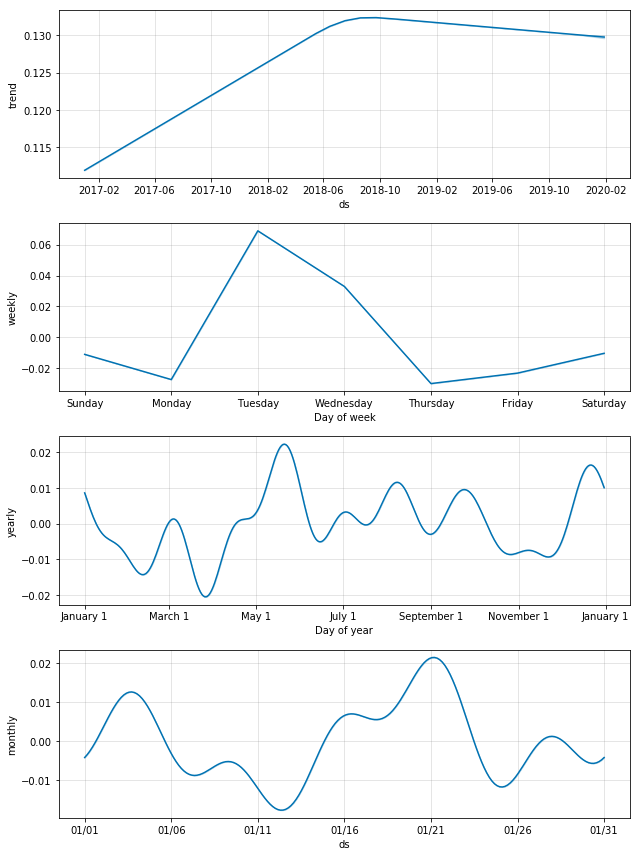

2: ライブコミュニケーション_01.multi_device


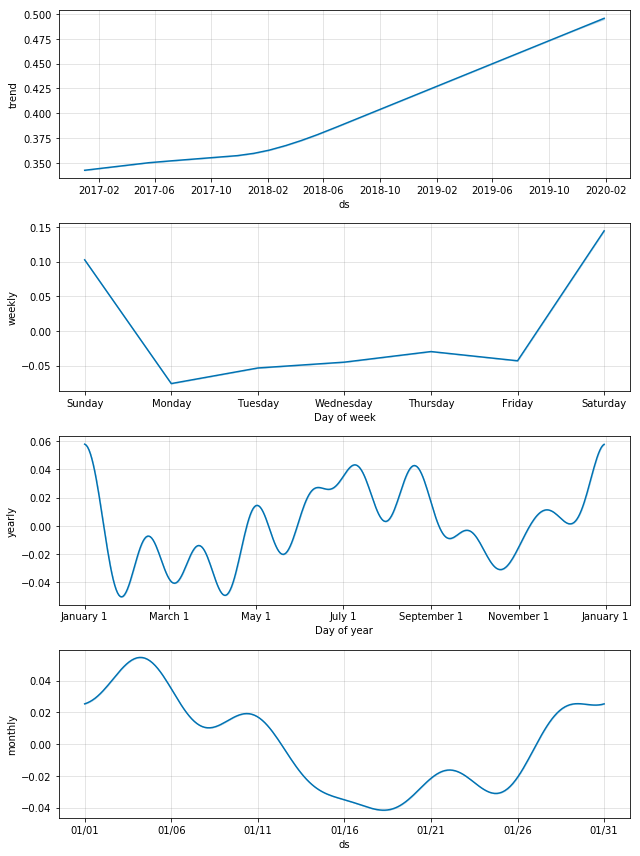

3: 同人_01.multi_device


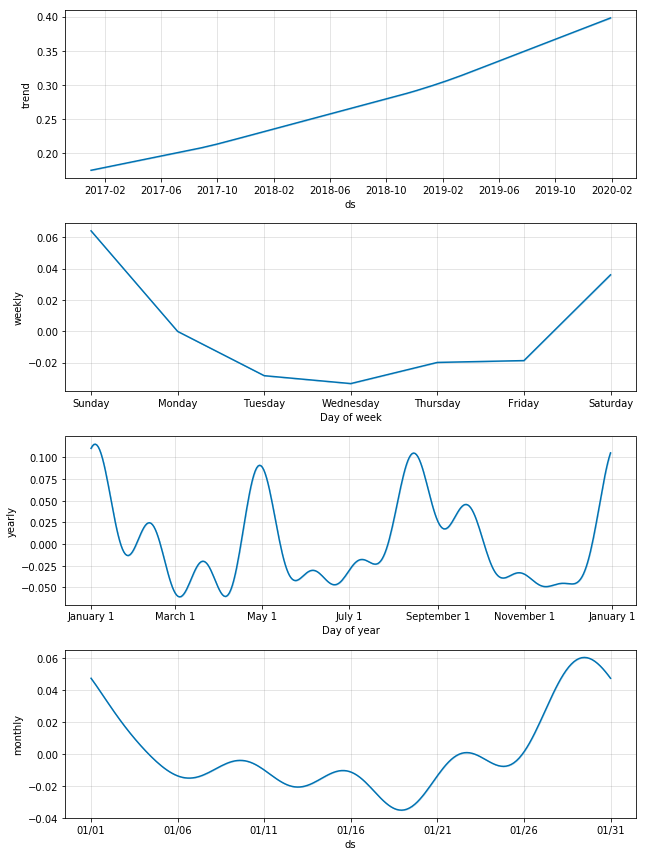

4: 電子書籍_01.multi_device


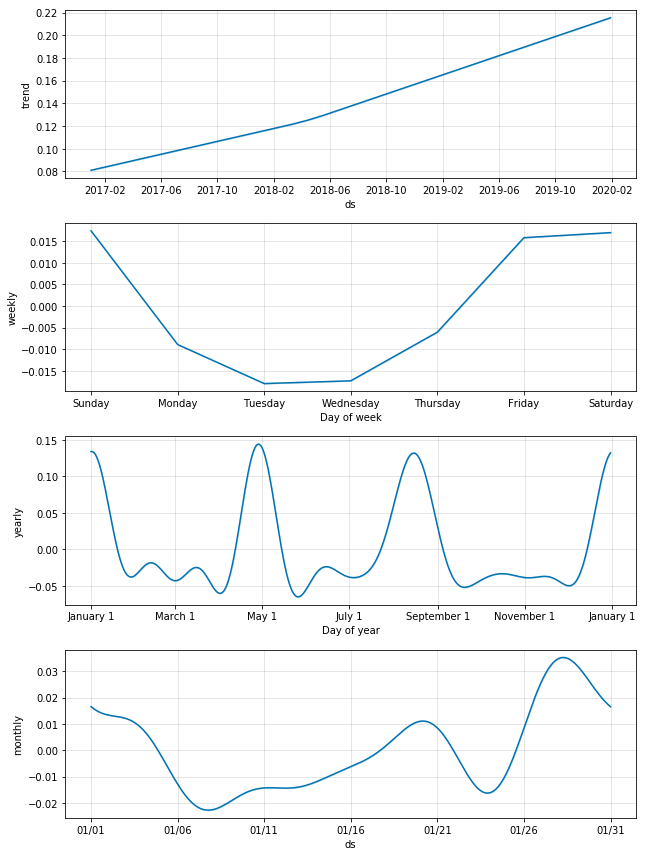

5: 動画_01.multi_device


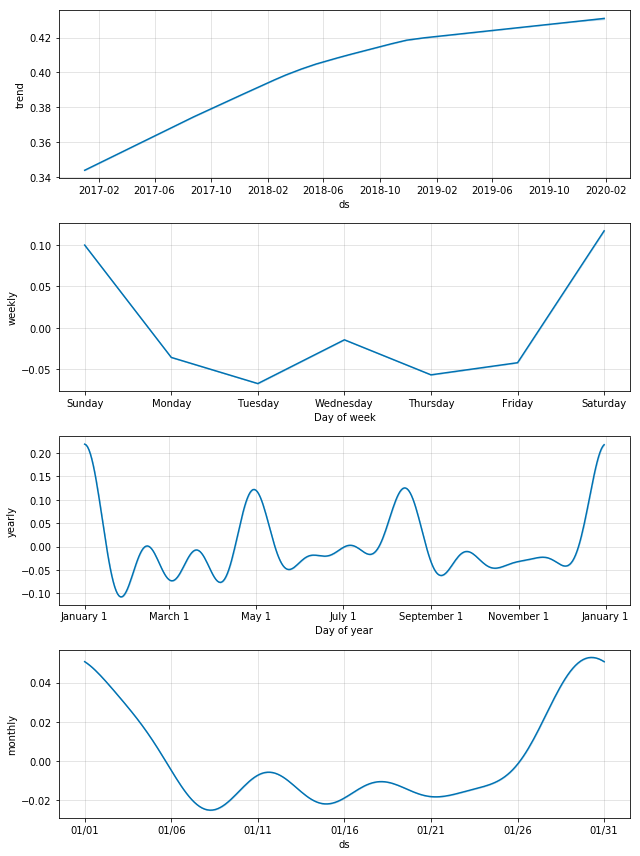

6: ゲーム_02.pc_only


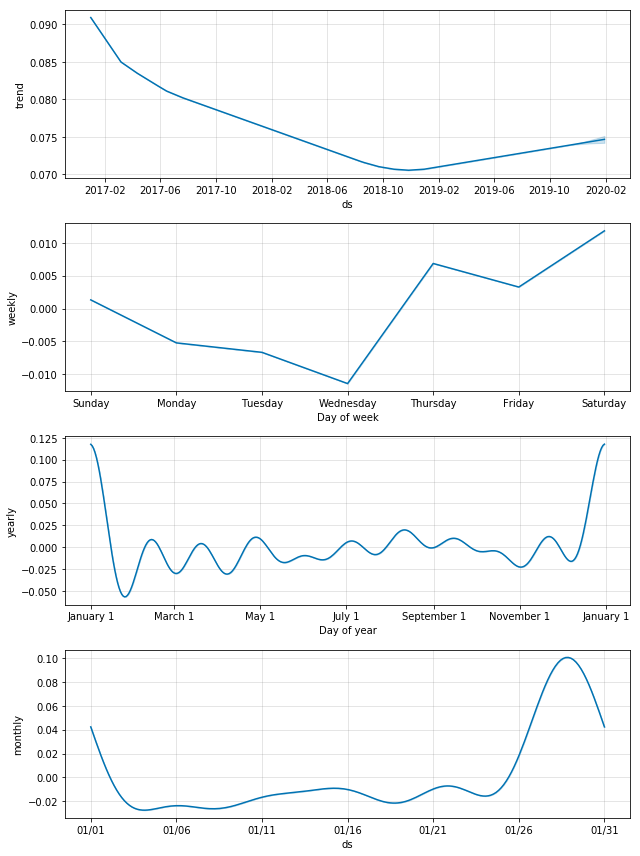

7: その他_02.pc_only


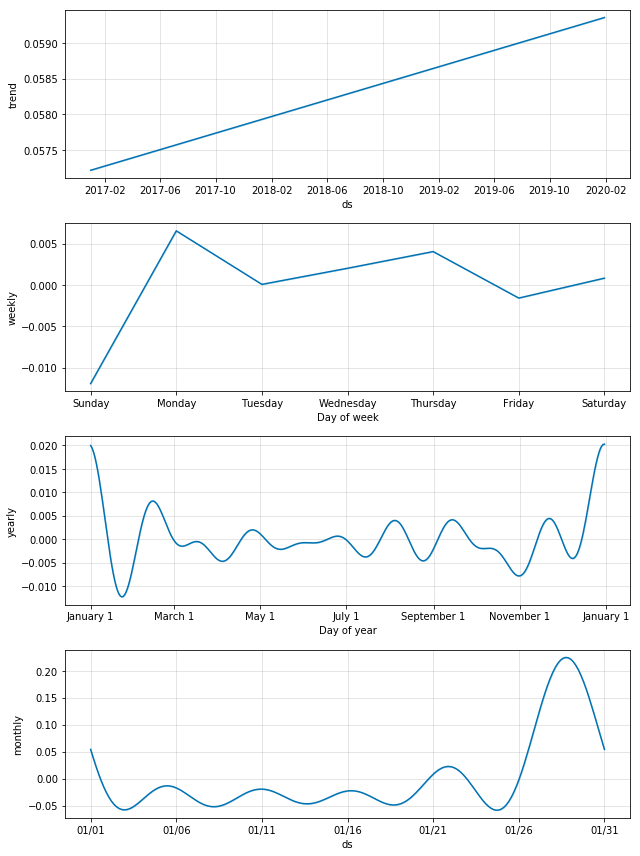

8: ライブコミュニケーション_02.pc_only


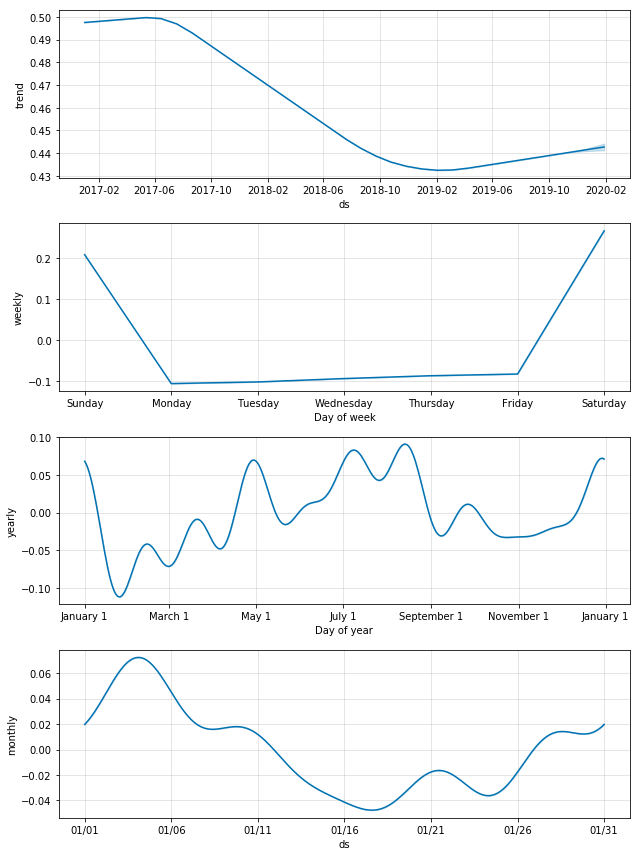

9: 同人_02.pc_only


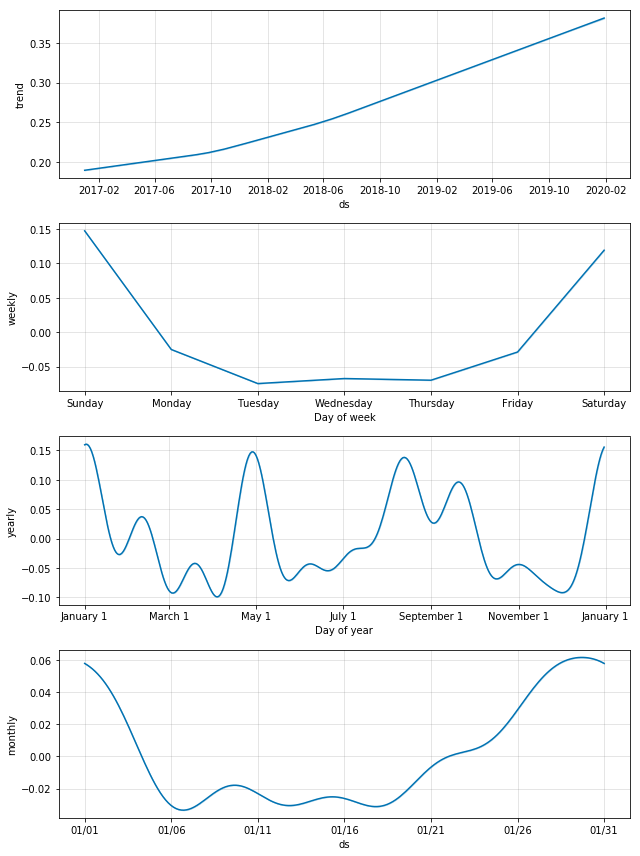

10: 電子書籍_02.pc_only


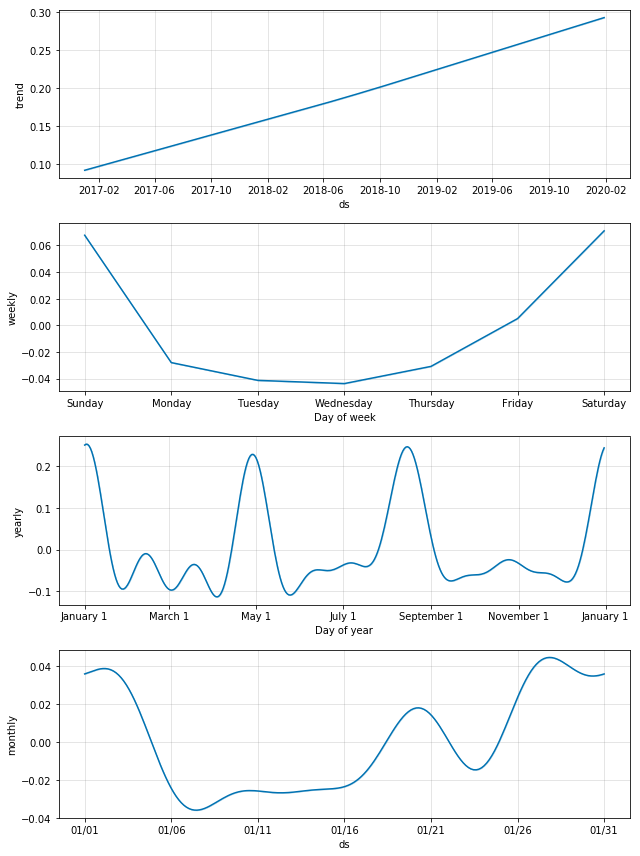

11: 動画_02.pc_only


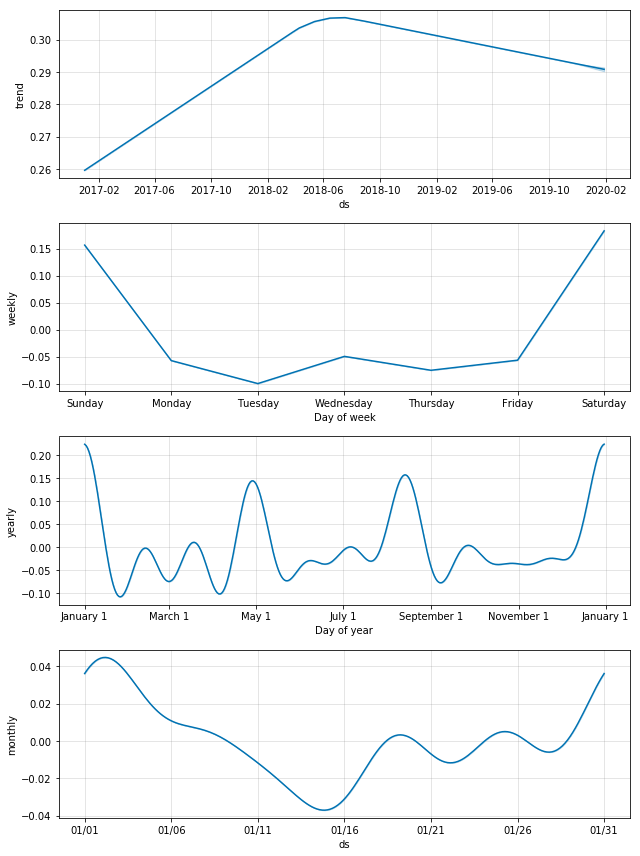

12: ゲーム_03.sp_only


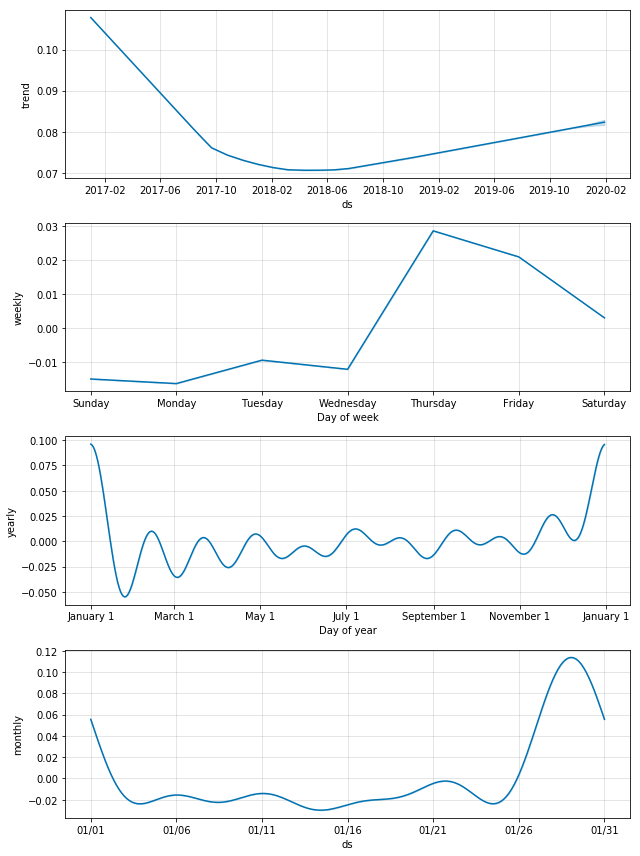

13: その他_03.sp_only


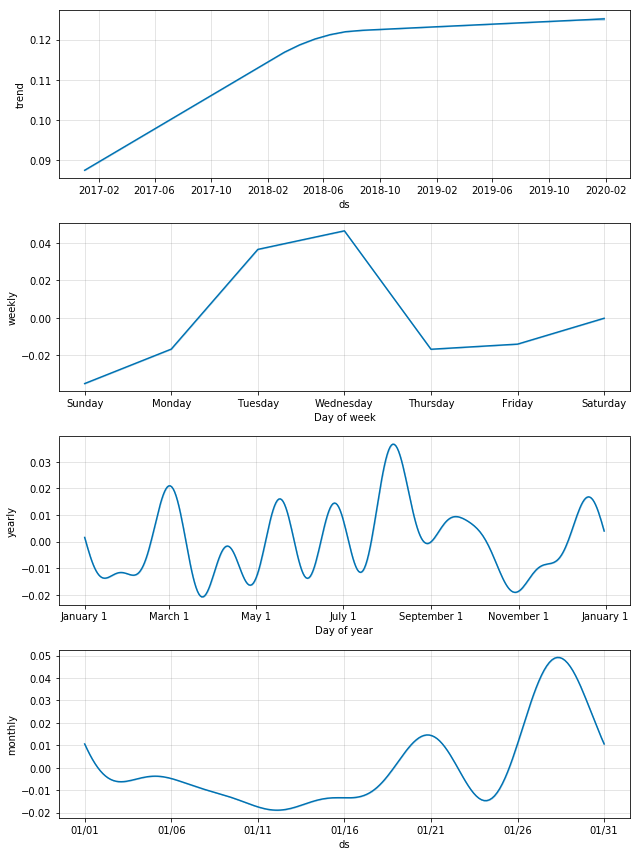

14: ライブコミュニケーション_03.sp_only


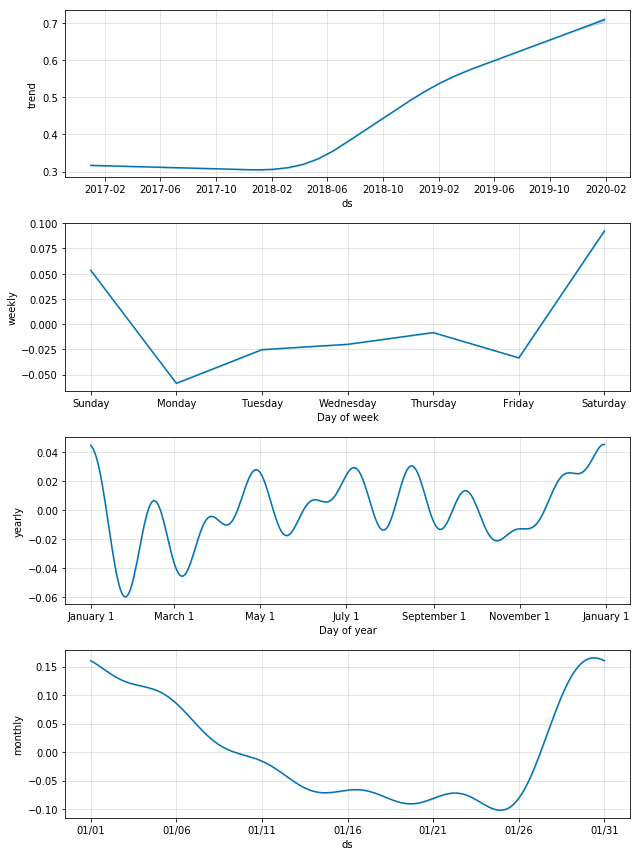

15: 同人_03.sp_only


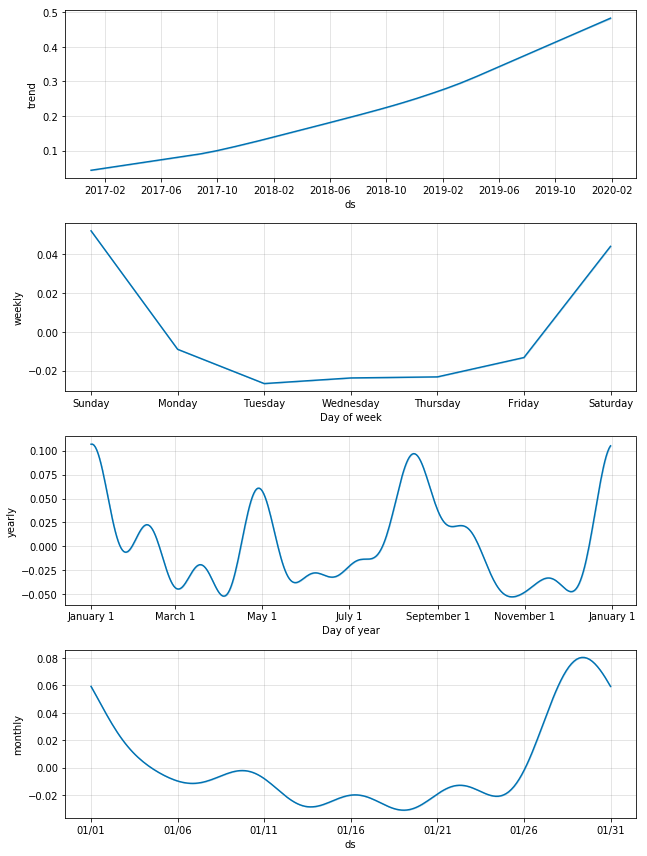

16: 電子書籍_03.sp_only


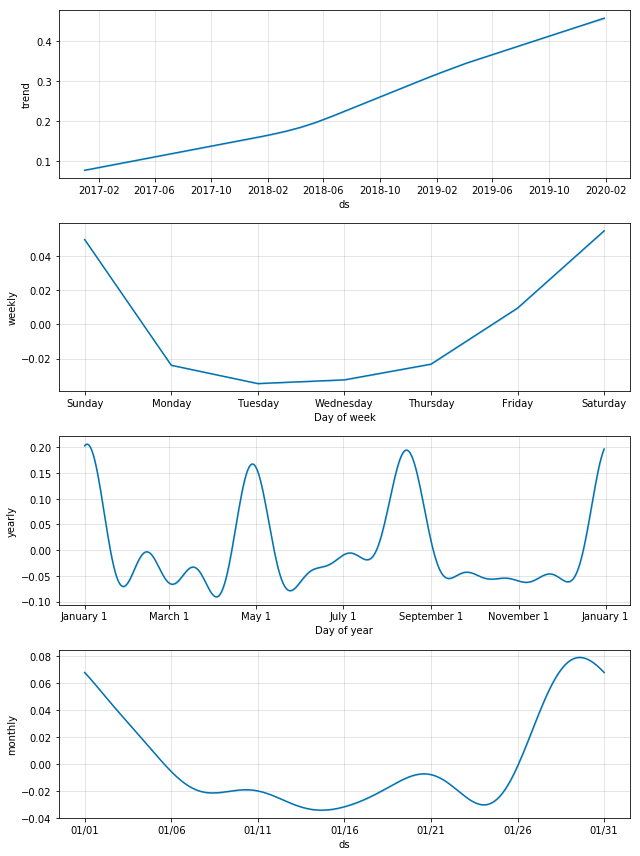

17: 動画_03.sp_only


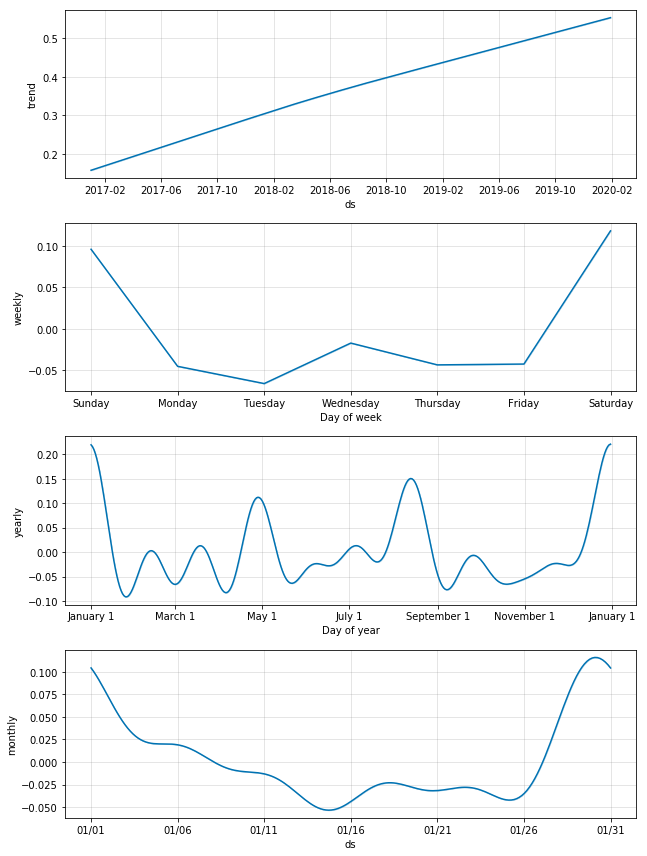

In [81]:
for i in range(len(category_list)):
    print(f'{i}: {category_list[i]}')
    model_list[i].plot_components(forecast_list[i])
    plt.show()

In [87]:
import math
from sklearn.metrics import mean_squared_error

# 二乗平均誤差を計算する　
score_list = []
scaled_score_list =[]
for i in range(len(category_list)):
    score_list.append(math.sqrt(mean_squared_error(scaled_dataset_list[i][:], forecast_list[i]['yhat'][:-90])))

In [88]:
# 誤差の平均
print(f'score Av: {sum(score_list)/len(score_list)}')

score Av: 0.16040280580248478


### まとめ
- 事業×デバイス別に、2016-01-01 ~ 2019-10-31の期間のデータの売上の予測
- 売上実測値と予測のRSMEを評価指標とした
- 誤差の平均をLSTM（Test Score Av: 0.1327355063733471）と比較すると少しProphetの方が悪い